
___
# Logistic Regression with Python

For this dummy project, I will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set.

We'll be trying to predict a classification- survival or deceased.

Let's import some libraries to get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [2]:
train_titanic = pd.read_csv('titanic_train.csv')

In [3]:
train_titanic.head()

# sibsp - siblings abroad
# parch - parents or children abroad
# embarked - from where they belong to
# pclass - passenger class

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

<AxesSubplot:>

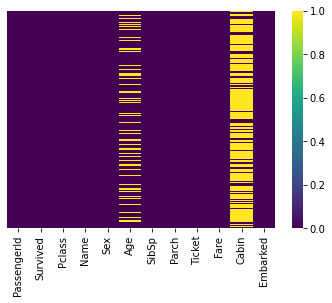

In [9]:
sns.heatmap(train_titanic.isnull(),yticklabels=False,cbar=True,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data!

<AxesSubplot:xlabel='Survived', ylabel='count'>

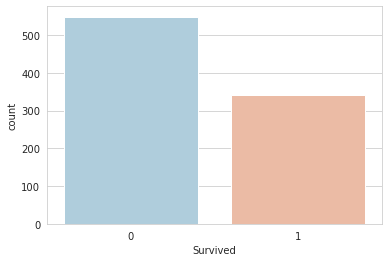

In [16]:
# sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train_titanic,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

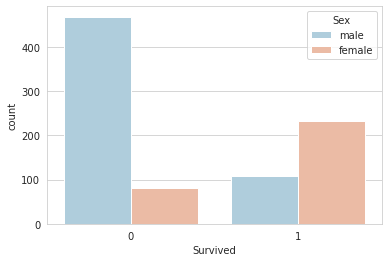

In [12]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train_titanic,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

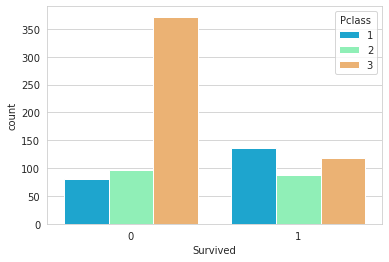

In [15]:
# sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train_titanic,palette='rainbow')

This shows that people from cheap class survival rate is far less than the other class. 

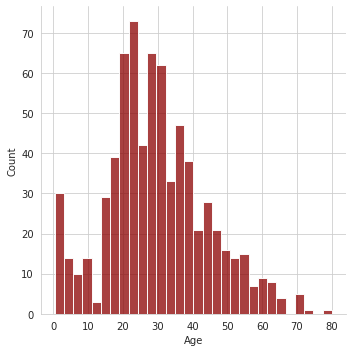

In [19]:
# Distplot takes in array of values
sns.displot(train_titanic['Age'].dropna(),kde=False,color='darkred',bins=30)

<AxesSubplot:>

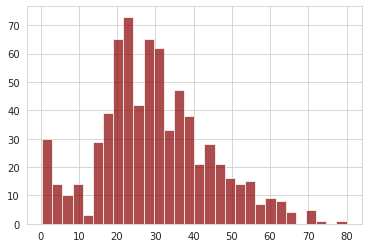

In [21]:
#using pandas own visulization technique
train_titanic['Age'].hist(bins=30,color='darkred',alpha=0.7)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

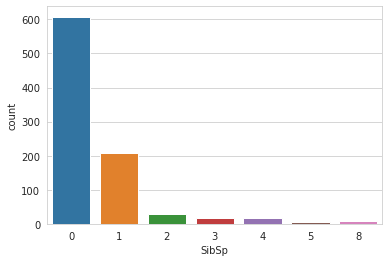

In [22]:
sns.countplot(x='SibSp',data=train_titanic)

looking at the above plot, we can say that most people onboard doesn't have siblings or spouse with them.

<AxesSubplot:>

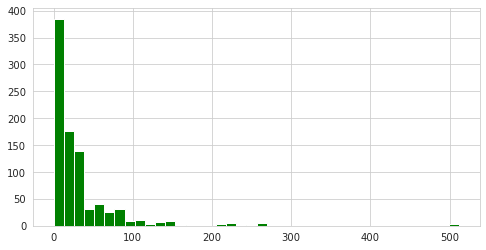

In [23]:
train_titanic['Fare'].hist(color='green',bins=40,figsize=(8,4))

____
### Cufflinks for plots
___
 Let's take a quick moment to show an example of cufflinks!

In [26]:
import cufflinks as cf
cf.go_offline()

In [27]:
train_titanic['Fare'].iplot(kind='hist',bins=30,color='green')

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (<b>imputation</b>).
However we can be smarter about this and check the average age by passenger class. For example:


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

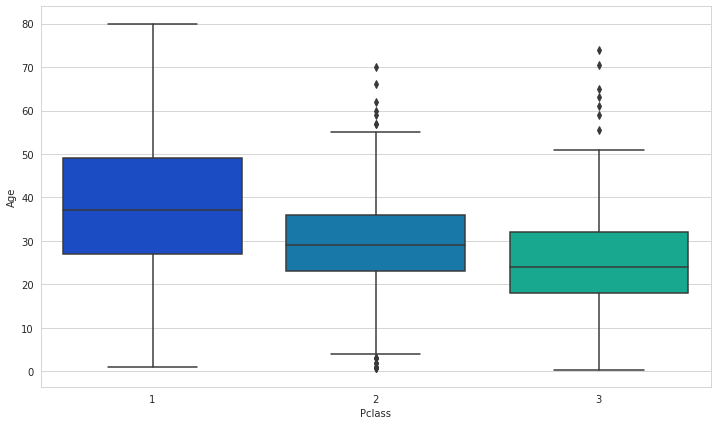

In [28]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train_titanic,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [29]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [31]:
train_titanic['Age'] = train_titanic[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

<AxesSubplot:>

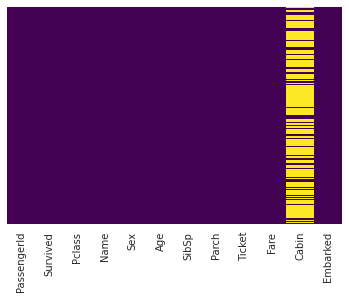

In [32]:
sns.heatmap(train_titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [34]:
train_titanic.drop('Cabin',axis=1,inplace=True)

In [35]:
train_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [36]:
train_titanic.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [37]:
train_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [39]:
train_titanic['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [41]:
#There are 3 categories of 'Embarked' column and 2 for 'sex' column. 

sex = pd.get_dummies(train_titanic['Sex'],drop_first=True)
embark = pd.get_dummies(train_titanic['Embarked'],drop_first=True)

In [42]:
# now we will drop those columns which we won't use in our model like columns whose data type is object.

train_titanic.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [43]:
train_titanic = pd.concat([train_titanic,sex,embark],axis=1)

In [44]:
train_titanic.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [45]:
# 'passengerId' is just an index number doesn't give any information about the passengers. so we can 
# just drop that column. Moreover 'Pclass' is a categorical feature, we can create dummies column for that 
# and build a different model using this to compare the two models.

Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [48]:
y_actual = train_titanic['Survived']
X = train_titanic.drop('Survived', axis = 1)

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y_actual, test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [58]:
logisticModel = LogisticRegression(max_iter=500)


In [59]:
logisticModel.fit(X_train,y_train)

LogisticRegression(max_iter=500)

In [61]:
predictions = logisticModel.predict(X_test)

Let's move on to evaluate our model!

## Evaluation

We can check precision,recall,f1-score using classification report!

In [63]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       163
           1       0.84      0.68      0.75       104

    accuracy                           0.82       267
   macro avg       0.83      0.80      0.81       267
weighted avg       0.83      0.82      0.82       267



In general, if you are working with an imbalanced dataset where all classes are equally important, using the macro average would be a good choice as it treats all classes equally. It means that for our example involving the classification of airplanes, boats, and cars, we would use the macro-F1 score.

If you have an imbalanced dataset but want to assign greater contribution to classes with more examples in the dataset, then the weighted average is preferred. This is because, in weighted averaging, the contribution of each class to the F1 average is weighted by its size.

Suppose you have a balanced dataset and want an easily understandable metric for overall performance regardless of the class. In that case, you can go with accuracy, which is essentially our micro F1 score.

In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[149,  14],
       [ 33,  71]])

We might want to explore other feature engineering and the other titanic_text.csv file like:-

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?
